# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [1]:
import functools

def robustness(direction, threshold, data):
    
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    elif direction == LARGER:
        return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]

def inertia(data):
    return np.sum(data>=0.6)/data.shape[0]

def reliability(data):
    return np.sum(data>=0.99)/data.shape[0]

def utility(data):
    return np.sum(data>=0.75)/data.shape[0]


    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [2]:
from dps_lake_model import lake_model
from ema_workbench import (Model, MultiprocessingEvaluator, RealParameter, SequentialEvaluator, ScalarOutcome, ema_logging, Constraint, perform_experiments, Policy)
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from dps_lake_model import lake_model
import numpy as np
import pandas as pd

In [3]:
model = Model('LAKE', function=lake_model)

# Setting the model uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# Assigning the model levers

model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

# Deciding upon the outcomes
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE, expected_range=(0,5)),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,2)),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,1)),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,1))]

In [4]:
from ema_workbench import (perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework import samplers
from ema_workbench.em_framework import util

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 500
n_policies = 4
fn = './results/{} scenarios {} policies.tar.gz'.format(n_scenarios, n_policies)

counter = util.Counter()
policies = samplers.sample_levers(model, n_policies, sampler = samplers.MonteCarloSampler())
scenarios = samplers.sample_levers(model, n_scenarios, sampler = samplers.MonteCarloSampler())

In [5]:
with MultiprocessingEvaluator(model) as evaluator:
     results = evaluator.perform_experiments(scenarios, policies)
save_results(results, fn)
experiments, outcomes=results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\Meron Znabei\Desktop\EPA\Courses\Model-based Decision-making\epa1361_open-master\Week 5-6 - robustness and direct search\results\500 scenarios 4 policies.tar.gz


In [6]:
policies_t = experiments['policy']
for i, policy in enumerate(np.unique(policies_t)):
    experiments.loc[policies_t==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies_t

In [7]:
data.head()

,max_P,utility,inertia,reliability,policy
0,2.283851,1.734761,0.99,0.07,0
1,2.283726,1.734761,0.99,0.07,0
2,2.283878,1.734761,0.99,0.07,0
3,2.283843,1.734761,0.99,0.07,0
4,2.283825,1.734761,0.99,0.07,0


## Robustness

In [8]:
#max_P:
robustness_max_p=robustness('SMALLER',0.75, data['max_P'])

#utillity:
robustness_utility=robustness('LARGER',0.75, data['utility'])

#inertia:
robustness_inertia=robustness('LARGER',0.6, data['inertia'])

#reliability:
robustness_reliability=robustness('LARGER',0.99, data['reliability'])

robustness_metrics={'max_P': robustness_max_p, 'utility':robustness_utility, 'inertia': robustness_inertia, 'reliability': robustness_reliability}

In [9]:
print(robustness_metrics)

{'max_P': 0.0, 'utility': 1.0, 'inertia': 1.0, 'reliability': 0.0}


As seen above, around 25% of scenarios fall within the threshold defined for max_P and reliability. Same holds for Inertia as within all scenarios, each of them was indeed higher than 0.6

In [10]:
potential_solutions=data.loc[(data['max_P']<=0.75) & (data['inertia']>=0.6) & (data['reliability']>=0.25) &(data['utility']>=0.75)]

In [11]:
potential_solutions.head()

,max_P,utility,inertia,reliability,policy


However, as checked in the code above, no policy proposed for any scenario will end up satisfying all of these conditions. Threfore, even though policies might show to be robust for a specific metric, they do not ensure the expected behaviour in other variables. 

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [12]:
maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)


MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE
robustness_functions = [ScalarOutcome('max_P', kind=MAXIMIZE,
                             variable_name='max_P', function=maxp),
                       ScalarOutcome('reliability', kind=MAXIMIZE,
                             variable_name='reliability', function=reliability),
                       ScalarOutcome('inertia', kind=MAXIMIZE,
                             variable_name='inertia', function=inertia),
                       ScalarOutcome('utility', kind=MAXIMIZE,
                             variable_name='utility', function=utility)]



In [13]:
#Test if it is okay with Sequential
nfe = 100

with MultiprocessingEvaluator(model) as evaluator:
    robust_results = evaluator.robust_optimize(robustness_functions, scenarios=5,
                            nfe=nfe, epsilons=[0.05,]*len(robustness_functions))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100 nfe
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


In [14]:
robust_results.head()

,c1,c2,r1,r2,w1,max_P,reliability,inertia,utility
0,-0.576214,1.776188,0.363908,0.949904,0.119218,0.0,0.0,1.0,0.6
1,-0.405220,0.522403,1.447665,1.331391,0.014859,0.8,0.8,1.0,0.0
2,0.633372,-0.150937,1.722719,1.315472,0.257133,0.6,0.6,1.0,0.2
3,0.164294,1.534897,1.997078,1.734133,0.825269,0.4,0.4,1.0,0.4


In [15]:
#Actual, could not run it because my computer is way to slow 
nfe = 200
n_scenarios = 50
scenarios = samplers.sample_levers(model, n_scenarios, sampler = samplers.MonteCarloSampler())

In [16]:
convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

In [17]:
with MultiprocessingEvaluator(model) as evaluator:
    robust_results, convergence= evaluator.robust_optimize(robustness_functions, scenarios=scenarios,
                                    nfe=nfe, epsilons=[0.05,]*len(robustness_functions),
                                    convergence=convergence_metrics)
    
#takes too much time but cant make it run

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/200 nfe
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

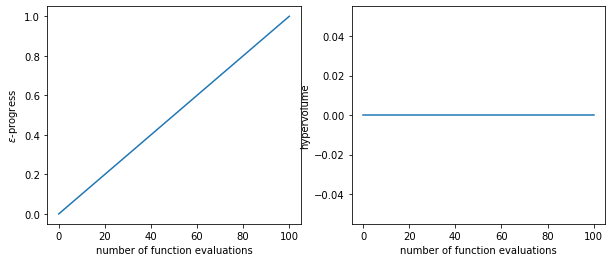

In [18]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(10,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [19]:
robust_results

,c1,c2,r1,r2,w1,max_P,reliability,inertia,utility
0,1.928682,1.249929,0.575183,1.790282,0.201520,0.0,0.0,1.0,1.0
1,0.422249,0.551670,0.904646,0.915699,0.597599,1.0,1.0,1.0,0.0


In [20]:
policies = []
for i in range(len(robust_results)):
    policy_dict = robust_results.loc[i].to_dict()
    print(policy_dict)
    name = "Policy " + str(i)
    policies.append(Policy(name, **policy_dict))

{'c1': 1.928681978894784, 'c2': 1.2499291628456044, 'r1': 0.5751828656246758, 'r2': 1.790281574844895, 'w1': 0.20151971037113958, 'max_P': 0.0, 'reliability': 0.0, 'inertia': 1.0, 'utility': 1.0}
{'c1': 0.4222491804286981, 'c2': 0.5516698097744079, 'r1': 0.9046458300154276, 'r2': 0.9156987057552131, 'w1': 0.5975993292794661, 'max_P': 1.0, 'reliability': 1.0, 'inertia': 1.0, 'utility': 0.0}


In [21]:
policies

[Policy({'c1': 1.928681978894784, 'c2': 1.2499291628456044, 'r1': 0.5751828656246758, 'r2': 1.790281574844895, 'w1': 0.20151971037113958, 'max_P': 0.0, 'reliability': 0.0, 'inertia': 1.0, 'utility': 1.0}),
 Policy({'c1': 0.4222491804286981, 'c2': 0.5516698097744079, 'r1': 0.9046458300154276, 'r2': 0.9156987057552131, 'w1': 0.5975993292794661, 'max_P': 1.0, 'reliability': 1.0, 'inertia': 1.0, 'utility': 0.0})]

In [22]:
n_scenarios = 1000
scenarios = samplers.sample_levers(model, n_scenarios, sampler = samplers.MonteCarloSampler())

with MultiprocessingEvaluator(model) as evaluator:
     results_reev = evaluator.perform_experiments(scenarios, policies)
save_results(results_reev, fn)
experiments, outcomes=results_reev

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 2 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\Meron Znabei\Desktop\EPA\Courses\Model-based Decision-making\epa1361_open-master\Week 5-6 - robustness and direct search\results\500 scenarios 4 policies.tar.gz


In [23]:
policies_t = experiments['policy']
for i, policy in enumerate(np.unique(policies_t)):
    experiments.loc[policies_t==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies_t

In [24]:
#max_P:
robustness_max_p=robustness('SMALLER',0.75, data['max_P'])

#utillity:
robustness_utility=robustness('LARGER',0.75, data['utility'])

#inertia:
robustness_inertia=robustness('LARGER',0.6, data['inertia'])

#reliability:
robustness_reliability=robustness('LARGER',0.99, data['reliability'])

robustness_metrics={'max_P': robustness_max_p, 'utility':robustness_utility, 'inertia': robustness_inertia, 'reliability': robustness_reliability}
print(robustness_metrics)

{'max_P': 0.5, 'utility': 0.5, 'inertia': 1.0, 'reliability': 0.5}


In the previous section, we stated that 'even though policies might show to be robust for a specific metric, they do not ensure the expected behaviour in other variables'. After looking at 1000 scenario's, this behaviour changes. As seen in the cell above, the robustness scores are more spread evenly. All outcomes satisfy the treshhold at least in 50% of the cases. The robustness score for Inertia stayed the same. But you see that a tradeoff was made in the utility score. The total robustness scores are in fact higher. 

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?

In [47]:
fn = 'results/results_A9.csv'

results_mordm = pd.read_csv(fn)

In [48]:
results_mordm.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'c1', 'c2', 'r1', 'r2', 'w1', 'max_P',
       'utility', 'inertia', 'reliability'],
      dtype='object')

In [49]:
results_mordm = results_mordm.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
results_mordm

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.139470,0.732439,1.936407,0.731837,0.140452,0.362343,0.680375,0.9900,1.0000
1,0.544591,0.757380,1.508835,0.841392,0.089422,0.357023,0.674533,0.9900,1.0000
2,0.689882,0.789645,1.483917,0.934381,0.101484,0.349163,0.663636,0.9900,1.0000
3,1.050547,0.726518,1.977901,0.841315,0.131709,0.337741,0.645467,0.9900,1.0000
4,0.066645,0.680527,1.816996,0.720498,0.233590,0.329844,0.631620,0.9900,1.0000
5,0.353821,0.752348,1.160446,0.805602,0.137735,0.359875,0.630114,0.9900,1.0000
6,0.756049,0.781679,0.549234,1.210774,0.132341,0.346863,0.615534,0.9900,1.0000
7,0.665296,0.746020,1.644257,0.938127,0.095022,0.319827,0.612800,0.9900,1.0000
8,0.647738,0.782646,0.652413,1.009411,0.350368,0.338818,0.604742,0.9900,1.0000
9,0.684128,0.724525,1.949228,0.923092,0.100469,0.309968,0.593222,0.9900,1.0000


In [50]:
policies_2 = []
for i in range(len(results_mordm)):
    policy_dict_2 = results_mordm.loc[i].to_dict()
    print(policy_dict_2)
    name = "Policy " + str(i)
    policies_2.append(Policy(name, **policy_dict_2))

{'c1': 0.1394696167557721, 'c2': 0.7324385000136222, 'r1': 1.9364068757644208, 'r2': 0.7318369652103747, 'w1': 0.1404515107576862, 'max_P': 0.3623426802261487, 'utility': 0.680374645255356, 'inertia': 0.9900000000000014, 'reliability': 1.0000000000000009}
{'c1': 0.5445906549872547, 'c2': 0.7573798417989809, 'r1': 1.5088352368660831, 'r2': 0.8413915723611088, 'w1': 0.0894222470515234, 'max_P': 0.3570230963248284, 'utility': 0.6745325342853473, 'inertia': 0.9900000000000014, 'reliability': 1.0000000000000009}
{'c1': 0.6898819447814157, 'c2': 0.7896446376237672, 'r1': 1.4839171354523195, 'r2': 0.9343814459128136, 'w1': 0.1014835904693878, 'max_P': 0.349162512148263, 'utility': 0.6636364671579135, 'inertia': 0.9900000000000014, 'reliability': 1.0000000000000009}
{'c1': 1.050547292082077, 'c2': 0.726518052696687, 'r1': 1.9779007155803368, 'r2': 0.841315369921221, 'w1': 0.1317089764420835, 'max_P': 0.3377410599902022, 'utility': 0.6454667038922253, 'inertia': 0.9900000000000014, 'reliability

In [53]:
with MultiprocessingEvaluator(model) as evaluator:
     results_reev_mordm = evaluator.perform_experiments(scenarios, policies_2)
save_results(results_reev_mordm, fn)
experiments, outcomes=results_reev_mordm

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 50 policies * 1 model(s) = 50000 experiments
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 25000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] 35000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] 45000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\Meron Znabei\Desktop\EPA\Courses\Model-based Decision-making\epa1361_open-master\Week 5-6 - robustness and direct search\results\results_A9.csv


In [54]:
policies_t = experiments['policy']
for i, policy in enumerate(np.unique(policies_t)):
    experiments.loc[policies_t==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies_t

In [55]:
#max_P:
robustness_max_p=robustness('SMALLER',0.75, data['max_P'])

#utillity:
robustness_utility=robustness('LARGER',0.75, data['utility'])

#inertia:
robustness_inertia=robustness('LARGER',0.6, data['inertia'])

#reliability:
robustness_reliability=robustness('LARGER',0.99, data['reliability'])

robustness_metrics={'max_P': robustness_max_p, 'utility':robustness_utility, 'inertia': robustness_inertia, 'reliability': robustness_reliability}
print(robustness_metrics)

{'max_P': 0.52, 'utility': 0.48, 'inertia': 1.0, 'reliability': 0.506}


The scores are almost the same. This shows that both ways incorporate the fact that there are multiple objectives very well. Moro required less computing power, since two policies instead of 50 realised an robustness score total that is more or less equal to Mordm.